# LSTM model for sentiment Analysis

In [ ]:
import joblib
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', 180)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## Read the embeddings and Labels

In [ ]:
X_train = joblib.load('train_embeddings.pkl')
y_train = pd.read_csv('training.csv')['label'].values

X_val = joblib.load('validation_embeddings.pkl')
y_val = pd.read_csv('validation.csv')['label'].values

X_test = joblib.load('test_embeddings.pkl')
y_test = pd.read_csv('test.csv')['label'].values

In [ ]:
train = pd.read_csv('training.csv')
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2
4,i am feeling grouchy,3


## Number of classes or emotions

In [ ]:
print("Unique labels in training set:", np.unique(y_train))
print("Min label:", np.min(y_train))
print("Max label:", np.max(y_train))

Unique labels in training set: [0 1 2 3 4 5]
Min label: 0
Max label: 5


- 0: sadness
- 1: joy
- 2: love
- 3: anger
- 4: fear
- 5: surprise

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (16000, 768), y_train shape: (16000,)
X_val shape: (2000, 768), y_val shape: (2000,)
X_test shape: (2000, 768), y_test shape: (2000,)


In [ ]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

## Convert the data into Dataset and DataLoader



In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings  # Lista de embeddings generados por RoBERTa
        self.labels = labels.squeeze()  # Lista de etiquetas

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
# Dataset type conversion
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
test_dataset = EmotionDataset(X_test, y_test)

# DataLoaderr to make use of batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
type(train_dataset), type(train_loader)

(__main__.EmotionDataset, torch.utils.data.dataloader.DataLoader)

## LSTM Model

Parameters:
- Input_size: Embeddings size
- Hidden_size: Number of neurons in the LSTM
- num_layers: Number of stacking LSTM
- output_size: number of emotions or classes

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # LSTM
    self.lstm = nn.LSTM(
        input_size,
        hidden_size,
        num_layers,
        dropout=dropout,
        batch_first=True
    )

    # Layer Normalization
    self.layer_norm = nn.LayerNorm(hidden_size)

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, hidden_size // 2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size // 2, hidden_size//4),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size//4, output_size)
    )

  def forward(self, x):
    if len(x.shape) == 2:
        x = x.unsqueeze(1)  # Agrega dimensión de secuencia (batch_size, 1, embedding_dim)

    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # LSTM output: output of all the hidden_state, hidde_state, cell_state
    lstm_out, (hidden, _) = self.lstm(x, (h0, c0))

    # Apply Layer Normalization to the last output of the LSTM
    lstm_out_norm = self.layer_norm(lstm_out[:, -1, :])

    # Classification layers
    output = self.classifier(lstm_out_norm)
    return output

### Entrenar y Evaluar

In [ ]:
def train_and_evaluate(
    model, train_loader, val_loader, criterion, optimizer,
    epochs=20, patience=5, device="cpu"
):
    best_val_f1 = 0
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_predictions = []
        train_true_labels = []

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Forward
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions for F1-score
            predictions = torch.argmax(outputs, dim=1)
            train_predictions.extend(predictions.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Calculate Training F1-score
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')
        train_f1_scores.append(train_f1)

        # Validation phase
        model.eval()
        val_predictions = []
        val_true_labels = []
        val_loss = 0

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Store predictions for F1-score
                predictions = torch.argmax(outputs, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate Validation F1-score
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
        val_f1_scores.append(val_f1)

        # Print epoch results
        if epoch % 5 == 0:
          print(f"Epoch {epoch+1}/{epochs}")
          print(f"Training Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
          print(f"Training F1-Score: {train_f1:.4f} | Validation F1-Score: {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()

    return train_losses, val_losses, train_f1_scores, val_f1_scores

In [ ]:
def plot_training_curves(train_losses, val_losses, train_f1_scores, val_f1_scores):
    plt.figure(figsize=(14, 6))

    # Losses (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # F1-scores (Training and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1-Score')
    plt.plot(val_f1_scores, label='Validation F1-Score')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Hiperparámetros

In [ ]:
embedding_dim = 768  # Embedding size
hidden_dim = 256
output_dim = 6  # Number of emotion or classes
num_layers = 2
dropout = 0.3

# Model
model = LSTM(embedding_dim, hidden_dim, num_layers, output_dim, dropout)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Train
train_losses, val_losses, train_f1_scores, val_f1_scores = train_and_evaluate(
    model, train_loader, val_loader, criterion,
    optimizer, epochs=100, patience=3, device="cpu"
)

Epoch 1/100
Training Loss: 1.2517 | Validation Loss: 1.1167
Training F1-Score: 0.4928 | Validation F1-Score: 0.5662
Epoch 6/100
Training Loss: 0.9288 | Validation Loss: 0.8814
Training F1-Score: 0.6483 | Validation F1-Score: 0.6666
Epoch 11/100
Training Loss: 0.8160 | Validation Loss: 0.8096
Training F1-Score: 0.6929 | Validation F1-Score: 0.6926
Epoch 16/100
Training Loss: 0.7441 | Validation Loss: 0.7995
Training F1-Score: 0.7179 | Validation F1-Score: 0.7046
Epoch 21/100
Training Loss: 0.6982 | Validation Loss: 0.7893
Training F1-Score: 0.7278 | Validation F1-Score: 0.7165
Epoch 26/100
Training Loss: 0.6710 | Validation Loss: 0.7874
Training F1-Score: 0.7415 | Validation F1-Score: 0.7212
Early stopping triggered


## Resultados

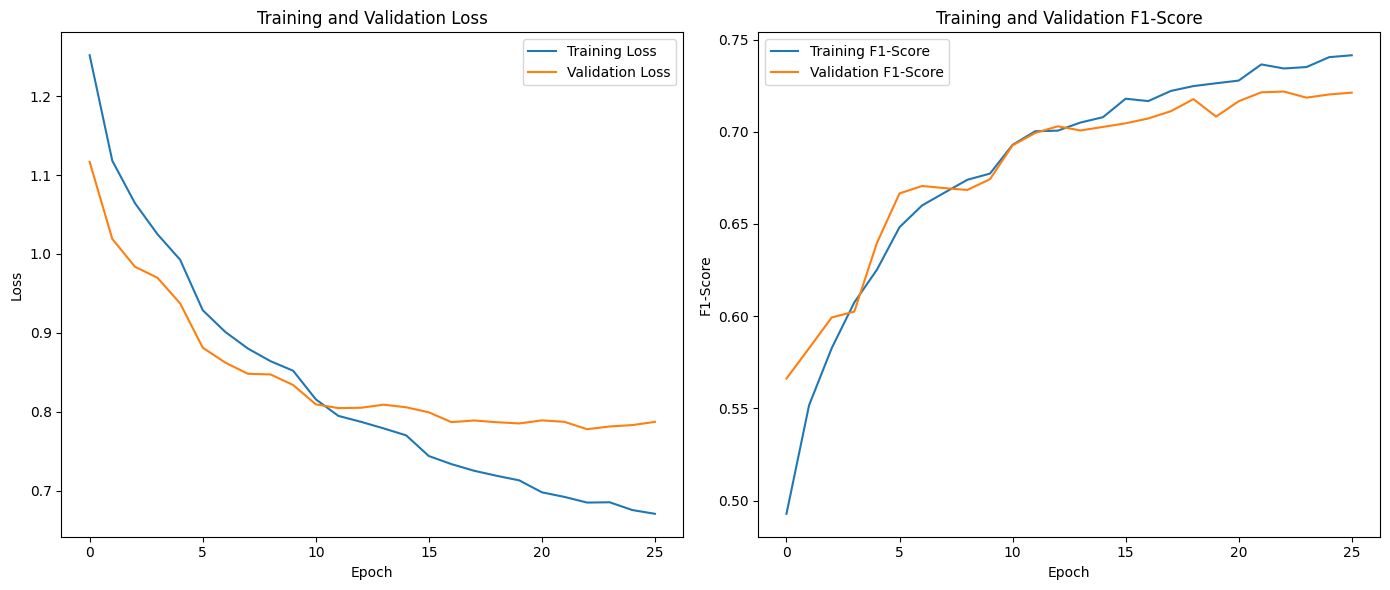

In [ ]:
plot_training_curves(train_losses, val_losses, train_f1_scores, val_f1_scores)

In [ ]:
# Results in the test set
device ='cpu'
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)

        # Store predictions for F1-score
        predictions = torch.argmax(outputs, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate Validation F1-score
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
print(f'Test F1-score: {test_f1:.4f}')

Test Accuracy: 0.7105
Test F1-score: 0.7050


### Confusion Matrix

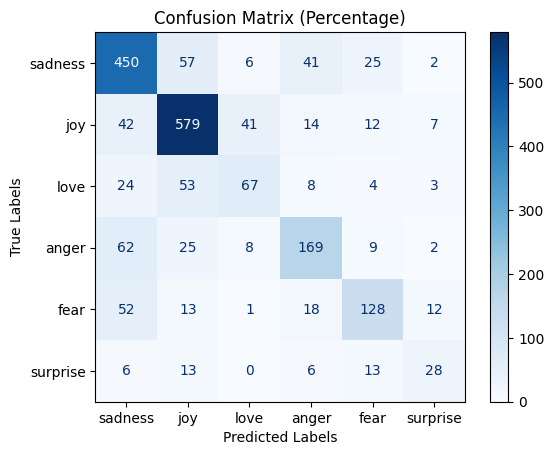

In [ ]:
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

cm = confusion_matrix(test_true_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Save the model

In [ ]:
model_save_path = 'modelo_emociones.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado en: {model_save_path}")

Modelo guardado en: modelo_emociones.pth


## Predicciones

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F # Import F

class TextPredictionPipeline:
    def __init__(self, lstm_model, device='cpu'):
        # Cargar el modelo LSTM entrenado
        self.lstm_model = lstm_model
        self.lstm_model.to(device)
        self.lstm_model.eval()

        # Cargar tokenizer y modelo
        self.tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.model.to(device)
        self.model.eval()
        self.device = device

        # Mapeo de etiquetas
        self.label_mapping = {
            0: "sadness",
            1: "joy",
            2: "love",
            3: "anger",
            4: "fear",
            5: "surprise"
        }

    def get_embedding(self, text):
        """Obtiene el embedding para un texto."""
        with torch.no_grad():
            # Tokenizar el texto
            inputs = self.tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(self.device)

            # Obtener embeddings
            outputs = self.model(**inputs)

            # Usar el embedding del token [CLS] (primer token)
            embeddings = outputs.last_hidden_state[:, 0, :]

            return embeddings

    def predict(self, text, return_probabilities=False):
        """
        Realiza una predicción para un texto dado.

        Args:
            text (str): Texto a clasificar
            return_probabilities (bool): Si es True, devuelve las probabilidades para cada clase

        Returns:
            str: Etiqueta predicha
            dict: Probabilidades por clase (opcional)
        """
        # Obtener embedding
        embedding = self.get_embedding(text)

        # Realizar predicción con el modelo LSTM
        with torch.no_grad():
            outputs = self.lstm_model(embedding)
            probabilities = F.softmax(outputs, dim=1) # Use F

            # Obtener la predicción
            predicted_class = torch.argmax(probabilities, dim=1).item()
            predicted_label = self.label_mapping[predicted_class]

            if return_probabilities:
                # Convertir probabilidades a diccionario
                probs_dict = {
                    label: prob.item()
                    for label, prob in zip(self.label_mapping.values(), probabilities[0])
                }
                return predicted_label, probs_dict

            return predicted_label

    def predict_batch(self, texts, return_probabilities=False):
        """
        Realiza predicciones para una lista de textos.

        Args:
            texts (list): Lista de textos a clasificar
            return_probabilities (bool): Si es True, devuelve las probabilidades para cada clase

        Returns:
            list: Lista de etiquetas predichas
            list: Lista de diccionarios con probabilidades (opcional)
        """
        # Obtener embeddings para todos los textos
        embeddings = torch.cat([self.get_embedding(text) for text in texts])

        # Realizar predicciones
        with torch.no_grad():
            outputs = self.lstm_model(embeddings)
            probabilities = F.softmax(outputs, dim=1) # Use F

            # Obtener predicciones
            predicted_classes = torch.argmax(probabilities, dim=1)
            predicted_labels = [self.label_mapping[cls.item()] for cls in predicted_classes]

            if return_probabilities:
                # Convertir probabilidades a lista de diccionarios
                probs_list = [
                    {label: prob.item() for label, prob in zip(self.label_mapping.values(), probs)}
                    for probs in probabilities
                ]
                return predicted_labels, probs_list

            return predicted_labels

In [ ]:
pipeline = TextPredictionPipeline(model, device='cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Hacer predicción para un solo texto
texto = "I am very happy"
prediccion = pipeline.predict(texto)
print(f"Emoción predicha: {prediccion}")

Emoción predicha: joy


In [ ]:
# Obtener predicción con probabilidades
prediccion, probabilidades = pipeline.predict(texto, return_probabilities=True)
print(f"Emoción predicha: {prediccion}")
print("Probabilidades por clase:")
for emocion, prob in probabilidades.items():
    print(f"{emocion}: {prob:.4f}")

Emoción predicha: joy
Probabilidades por clase:
sadness: 0.0000
joy: 0.9993
love: 0.0007
anger: 0.0000
fear: 0.0000
surprise: 0.0000


In [ ]:
# Hacer predicciones para varios textos a la vez
textos = [
    "I hate the sun",
    "I am very sad",
    "omg I can not believe it"
]
predicciones = pipeline.predict_batch(textos)
for texto, pred in zip(textos, predicciones):
    print(f"\nTexto: {texto}")
    print(f"Emoción predicha: {pred}")


Texto: I hate the sun
Emoción predicha: anger

Texto: I am very sad
Emoción predicha: sadness

Texto: omg I can not believe it
Emoción predicha: surprise
